# COSC2753 - Assignment 2 - Classify Images of Colon Cancer

**RMIT University Vietnam**

**Course:** COSC2753

**Group:** MK Sapiens

**Student 1:** Pham Cong Minh - s3818102

**Student 2:** Nguyen Bao Khang - s3817970

**Lecturer:** Dr. Duy Dang Pham Thien

**Submission Due Date:** 21 May 2021

## Main task
* Classify images according to whether given cell image represents a cancerous cells or not (isCancerous).
* Classify images according to cell-type, such as: fibroblast, inflammatory, epithelial or others.

## 1. Setup notebook

In [ ]:
# !pip install tensorflow
# !pip install keras
# !pip install opencv-python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


## 2. Data inspecting

### 2.1. Load csv files

In [2]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [3]:
main_data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
main_data.shape

(9896, 6)

In [4]:
extra_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [6]:
extra_data.shape

(10384, 4)

### 2.2. Inspect csv files

From the specifications, the main_data contains both cellType (0 to 3) and isCancerous (0 and 1), while extra_data only contains isCancerous.

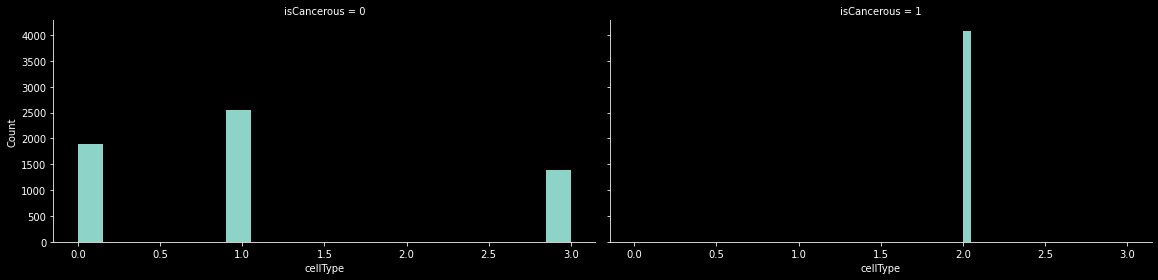

In [10]:
# Draw the histogram for cellType respected to isCancerous (class 0 and 1)
c = 'cellType'
g = sns.FacetGrid(main_data, col='isCancerous', height=4, aspect=2)
g.map(plt.hist, str(c), bins=20)
g.set_axis_labels(c, "Count")

In [15]:
# Apply loc to make sure
main_data.loc[(main_data['cellType'] != 2) & (main_data['isCancerous'] == 1)]

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous


From the dataset, it can be said that only cellType = 2 (epithelial) leads to cancerous 

### 2.3. Inspect images

In [16]:
# Prepare some image of each class
cell0 = main_data['ImageName'].loc[main_data['cellType'] == 0][:4].tolist()
cell1 = main_data['ImageName'].loc[main_data['cellType'] == 1][:4].tolist()
cell2 = main_data['ImageName'].loc[main_data['cellType'] == 2][:4].tolist()
cell3 = main_data['ImageName'].loc[main_data['cellType'] == 3][:4].tolist()

print(cell0)
print(cell1)
print(cell2)
print(cell3)

['22405.png', '22406.png', '22407.png', '22408.png']
['22417.png', '22418.png', '22419.png', '22420.png']
['276.png', '277.png', '278.png', '279.png']
['22423.png', '22424.png', '19061.png', '19062.png']


In [18]:
# CHANGE THE DIRECTORY IN YOUR LOCAL MACHINE
directory = r"C:\Users\Dell\Documents\GitHub\ML\Asm\ASM2\patch_images"

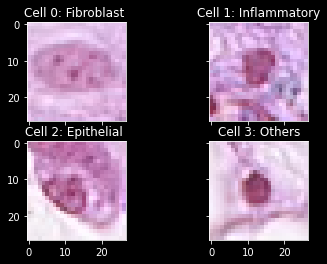

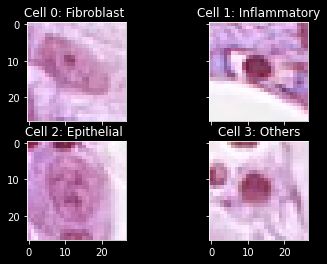

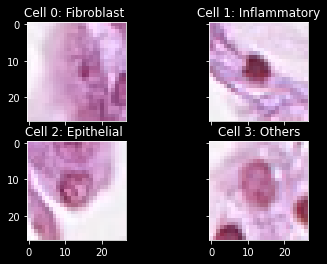

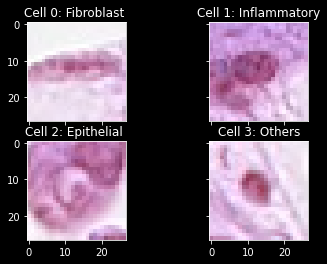

In [19]:
# Plotting 4 cellType
for i in range (4):
    # Read image
    cell_0 = cv2.imread(os.path.join(directory, cell0[i]))
    cell_1 = cv2.imread(os.path.join(directory, cell1[i]))
    cell_2 = cv2.imread(os.path.join(directory, cell2[i]))
    cell_3 = cv2.imread(os.path.join(directory, cell3[i]))

    # Create subplots
    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)
    
    # Draw cellType 0
    ax0.title.set_text("Cell 0: Fibroblast ")
    ax0.imshow(cell_0)
    
    # Draw cellType 1
    ax1.title.set_text("Cell 1: Inflammatory")
    ax1.imshow(cell_1)
    
    # Draw cellType 2
    ax2.title.set_text("Cell 2: Epithelial ")
    ax2.imshow(cell_2)
    
    # Draw cellType 3
    ax3.title.set_text("Cell 3: Others")
    ax3.imshow(cell_3)

    for ax in fig.get_axes():
        ax.label_outer()

### 3. Prepare data for training

### 3.1. Split data into train, validation, and test set

In [20]:
from sklearn.model_selection import train_test_split
X = main_data['ImageName']
y = main_data['cellType']

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.33)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_X.shape[0], val_X.shape[0], test_X.shape[0]))

Train data : 5304, Val Data: 1326, Test Data: 3266


In [21]:
# Ravel the labels
train_Y = train_Y.ravel()
val_Y = val_Y.ravel()
test_Y = test_Y.ravel()

### 3.2. Create image array

In [22]:
def create_train_data(directory, img_list):
    IMAGE_SIZE = 27
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (IMAGE_SIZE,IMAGE_SIZE))
        train_data.append(np.array(img))
    print("Successfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [23]:
train_X_img = create_train_data(directory, train_X.tolist())
val_X_img = create_train_data(directory, val_X.tolist())
test_X_img = create_train_data(directory, test_X.tolist())

Extracting Image Progress:  27%|█████████████▍                                    | 356/1326 [00:00<00:00, 3534.19it/s]

Successfully import images!


Extracting Image Progress:  16%|███████▉                                          | 521/3266 [00:00<00:00, 5172.23it/s]

Successfully import images!


Extracting Image Progress: 100%|█████████████████████████████████████████████████| 3266/3266 [00:00<00:00, 4645.02it/s]

Successfully import images!


### 3.3. Data Augmentation

Explaination...

#### 3.3.1 Define ImageDataGenerator

In [25]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True, 
                                   rotation_range=20, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest', 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2)

Params

#### 3.3.2 Preview augmentation

In [27]:
it = train_datagen.flow(train_X_img, train_Y)

ValueError: Input to `.fit()` should have rank 4. Got array with shape: (27, 27, 3)